# Fake News Detection



In an era of rapid digital information spread distinguishing real from fake news is challenging. The Fake News Detection Dataset helps researchers and data scientists train models for accurate fake news detection.

# SetUp

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

# Load Data

```
fake_and_real_news/
...Fake/
......news_article_1.txt
......news_article_2.txt
...Real/
......news_article_1.txt
......news_article_2.txt
```



In [3]:
# First split: Train (70%) and Temp (30% for val & test)
train_ds = tf.keras.utils.text_dataset_from_directory(
    'fake_and_real_news1',
    labels='inferred',
    label_mode='binary',
    class_names=['Fake', 'Real'],
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.3,
    subset='training'
)

raw_val_test_ds = tf.keras.utils.text_dataset_from_directory(
    'fake_and_real_news1',
    labels='inferred',
    label_mode='binary',
    class_names=['Fake', 'Real'],
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.3,
    subset='validation'
)

# Second split: Val (20%) and Test (10%)
val_size = int(0.67 * len(raw_val_test_ds))  # 67% of 30% = 20%
test_size = len(raw_val_test_ds) - val_size  # Remaining 10%

val_ds = raw_val_test_ds.take(val_size)
test_ds = raw_val_test_ds.skip(val_size)

# Print dataset sizes
print(f"Train size: {len(train_ds)} batches")
print(f"Validation size: {len(val_ds)} batches")
print(f"Test size: {len(test_ds)} batches")


Found 9900 files belonging to 2 classes.
Using 6930 files for training.
Found 9900 files belonging to 2 classes.
Using 2970 files for validation.
Train size: 217 batches
Validation size: 62 batches
Test size: 31 batches


In [4]:
# Now you should be able to use .take()
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("Article", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Article b'White House says Trump has confidence in Secretary of State Tillerson LAS VEGAS (Reuters) - U.S. President Donald Trump retains confidence in Secretary of State Rex Tillerson, White House spokeswoman Sarah Sanders said on Wednesday. \xe2\x80\x9cAs we\xe2\x80\x99ve said many times before, if the president doesn\xe2\x80\x99t have confidence in somebody, that person will not remain in that position,\xe2\x80\x9d Sanders told reporters on Air Force One.  She said Trump and Tillerson had not spoken on Wednesday. \tReal'
Label [1.]
Article b' Numbers Prove Trump A Liar: RECORD Job Growth Will Be The Legacy Of Obama Administration (DETAILS) Barack Obama has been accused again and again of ruining the economy but where s the proof? Oh wait, there is none because he s done the exact opposite of that. In fact, president Obama has broken records by creating jobs.According to the majority of Republicans, Obama has done just about nothing right. He gets zero credit for the good things he s

In [5]:
print("Label 0 corresponds to", train_ds.class_names[0])
print("Label 1 corresponds to", train_ds.class_names[1])

Label 0 corresponds to Fake
Label 1 corresponds to Real


# Data Preprocessing

standardize, tokenize, and vectorize the data using tf.keras.layers.TextVectorization layer.

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network.

the article contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). we will write a custom standardization function to remove the HTML.

Note: To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time.

In [6]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [7]:
max_words = 5000  # Vocabulary size
max_len = 200  # Max length per article

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=max_len)

calling adapt to fit the state of the preprocessing layer to the dataset to build an index of strings to integers.



In [8]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [9]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [10]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", train_ds.class_names[0])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'U.S. lawmakers ask DOJ if terrorism law covers pipeline activists WASHINGTON (Reuters) - U.S. representatives from both parties asked the Department of Justice on Monday whether the domestic terrorism law would cover actions by protesters that shut oil pipelines last year, a move that could potentially increase political rhetoric against climate change activists.  Ken Buck, a Republican representative from Colorado, said in a letter to Attorney General Jeff Sessions, that damaging pipeline infrastructure poses risks to humans and the environment.  The letter, a copy of which was seen by Reuters, said \xe2\x80\x9coperation of pipeline facilities by unqualified personnel could result in a rupture - the consequences of which would be devastating.\xe2\x80\x9d It was signed by 84 representatives, including at least two Democrats, Gene Green and Henry Cuellar, both of Texas. The move by the lawmakers is a sign of increasing tensions between activists protesting projects in

In [11]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  mind
 313 --->  executive
Vocabulary size: 5000


In [12]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

# Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

**.cache()** keeps data in memory after it's loaded off disk.

**.prefetch()** overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

In [14]:
embedding_dim = 16

In [15]:
model = tf.keras.Sequential([
  layers.Embedding(max_words, 128),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Loss function and optimizer

In [16]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

# Train the model

In [17]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping])

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - binary_accuracy: 0.7681 - loss: 0.4751 - val_binary_accuracy: 0.9819 - val_loss: 0.1402
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.9875 - loss: 0.1039 - val_binary_accuracy: 0.9874 - val_loss: 0.0609
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_accuracy: 0.9937 - loss: 0.0447 - val_binary_accuracy: 0.9929 - val_loss: 0.0387
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - binary_accuracy: 0.9965 - loss: 0.0259 - val_binary_accuracy: 0.9929 - val_loss: 0.0284
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - binary_accuracy: 0.9976 - loss: 0.0172 - val_binary_accuracy: 0.9950 - val_loss: 0.0227
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - binary_accuracy: 0.9989 - loss: 0.0120 - val_binary_accuracy: 0.9955 - val_loss: 0.0192
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_accuracy: 0.9995 - loss: 0.0084 - val_binary_accuracy: 0.9960 - val_loss: 0.0170

# Evaluate the model

In [18]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9948 - loss: 0.0197
Loss:  0.015790168195962906
Accuracy:  0.9949290156364441


# Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

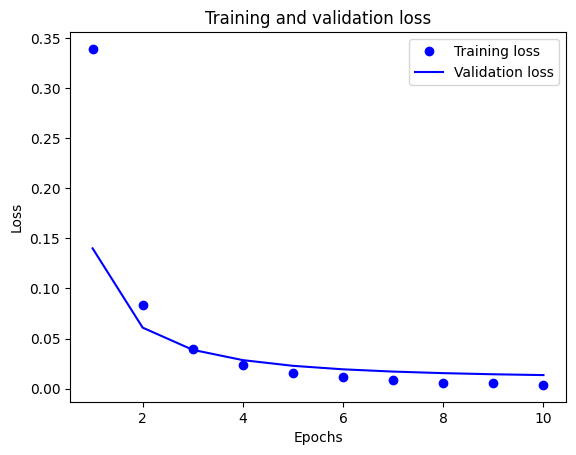

In [20]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

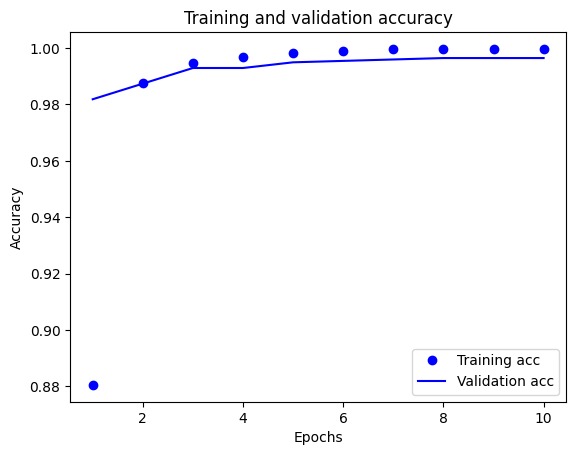

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export the model

In [22]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])



export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_val_test_ds`, which yields raw strings
raw_test_ds = raw_val_test_ds.skip(val_size)
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5421 - loss: 0.4989
{'accuracy': 0.5496957302093506, 'loss': 0.49974071979522705}


# Inference on new data


In [23]:
examples = tf.constant([
  "Mumbai Court orders corruption investigation FIR against Ex-SEBI chief Madhabi Puri Buch",
  "U.K., France will work with Ukraine to end war and present plan to Trump"])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


array([[0.72941136],
       [0.7288955 ]], dtype=float32)